In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install mmcv-full -f https://download.openmmlab.com/mmcv/dist/cu111/torch1.10.0/index.html
!git clone https://github.com/open-mmlab/mmsegmentation.git

Looking in links: https://download.openmmlab.com/mmcv/dist/cu111/torch1.10.0/index.html
     |████████████████████████████████| 46.3 MB 11.4 MB/s 
     |████████████████████████████████| 190 kB 5.1 MB/s 
Cloning into 'mmsegmentation'...
remote: Enumerating objects: 6986, done.
remote: Counting objects: 100% (19/19), done.
remote: Compressing objects: 100% (17/17), done.
remote: Total 6986 (delta 3), reused 7 (delta 2), pack-reused 6967
Receiving objects: 100% (6986/6986), 12.82 MiB | 35.67 MiB/s, done.
Resolving deltas: 100% (5177/5177), done.


In [ ]:
import torch

print(f"Setup complete. Using torch {torch.__version__} ({torch.cuda.get_device_properties(0).name if torch.cuda.is_available() else 'CPU'})")

Setup complete. Using torch 1.11.0+cu113 (Tesla P100-PCIE-16GB)


In [ ]:
%cd mmsegmentation
!pip install -e .

/content/mmsegmentation
Obtaining file:///content/mmsegmentation
     |████████████████████████████████| 572 kB 5.1 MB/s 
  Running setup.py develop for mmsegmentation


In [ ]:
from mmseg.apis import inference_segmentor, init_segmentor, show_result_pyplot
import mmcv

In [ ]:
import os.path as osp
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

In [ ]:
!mkdir checkpoints
!wget -O ///content/mmsegmentation/checkpoints/segformer_mit-b5_640x640_160k_ade20k_20210801_121243-41d2845b.pth https://download.openmmlab.com/mmsegmentation/v0.5/segformer/segformer_mit-b5_640x640_160k_ade20k/segformer_mit-b5_640x640_160k_ade20k_20210801_121243-41d2845b.pth

--2022-05-08 01:09:00--  https://download.openmmlab.com/mmsegmentation/v0.5/segformer/segformer_mit-b5_640x640_160k_ade20k/segformer_mit-b5_640x640_160k_ade20k_20210801_121243-41d2845b.pth
Resolving download.openmmlab.com (download.openmmlab.com)... 47.252.96.28
Connecting to download.openmmlab.com (download.openmmlab.com)|47.252.96.28|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 328404259 (313M) [application/octet-stream]
Saving to: ‘///content/mmsegmentation/checkpoints/segformer_mit-b5_640x640_160k_ade20k_20210801_121243-41d2845b.pth’

///content/mmsegmen 100%[===================>] 313.19M  5.87MB/s    in 44s     

2022-05-08 01:09:45 (7.10 MB/s) - ‘///content/mmsegmentation/checkpoints/segformer_mit-b5_640x640_160k_ade20k_20210801_121243-41d2845b.pth’ saved [328404259/328404259]



In [ ]:
from mmseg.datasets.builder import DATASETS
from mmseg.datasets.custom import CustomDataset

classes = ('background', 'building', 'road')
palette = [[0, 0, 0], [128, 128, 0], [128, 64, 128]]

@DATASETS.register_module()
class SIADataset(CustomDataset):
  CLASSES = classes
  PALETTE = palette
  def __init__(self, split, **kwargs):
    super().__init__(img_suffix='.png', seg_map_suffix='.png', 
                     split=split, **kwargs)
    assert osp.exists(self.img_dir) and self.split is not None

In [ ]:
# config 파일을 설정하고, 다운로드 받은 pretrained 모델을 checkpoint로 설정. 
config_file = '/content/mmsegmentation/configs/segformer/segformer_mit-b5_640x640_160k_ade20k.py'
checkpoint_file = '/content/mmsegmentation/checkpoints/segformer_mit-b5_640x640_160k_ade20k_20210801_121243-41d2845b.pth'

from mmcv import Config

cfg = Config.fromfile(config_file)
print(cfg.pretty_text)

norm_cfg = dict(type='SyncBN', requires_grad=True)
model = dict(
    type='EncoderDecoder',
    pretrained='pretrain/mit_b5.pth',
    backbone=dict(
        type='MixVisionTransformer',
        in_channels=3,
        embed_dims=64,
        num_stages=4,
        num_layers=[3, 6, 40, 3],
        num_heads=[1, 2, 5, 8],
        patch_sizes=[7, 3, 3, 3],
        sr_ratios=[8, 4, 2, 1],
        out_indices=(0, 1, 2, 3),
        mlp_ratio=4,
        qkv_bias=True,
        drop_rate=0.0,
        attn_drop_rate=0.0,
        drop_path_rate=0.1),
    decode_head=dict(
        type='SegformerHead',
        in_channels=[64, 128, 320, 512],
        in_index=[0, 1, 2, 3],
        channels=256,
        dropout_ratio=0.1,
        num_classes=150,
        norm_cfg=dict(type='SyncBN', requires_grad=True),
        align_corners=False,
        loss_decode=dict(
            type='CrossEntropyLoss', use_sigmoid=False, loss_weight=1.0)),
    train_cfg=dict(),
    test_cfg=dict(mode='whole'))
dataset_type = 

In [ ]:
model = dict(
    type='EncoderDecoder',
    pretrained='open-mmlab://resnet101_v1c',
    backbone=dict(
        type='ResNetV1c',
        depth=101,
        num_stages=4,
        out_indices=(0, 1, 2, 3),
        dilations=(1, 1, 1, 1),
        strides=(1, 2, 2, 2),
        norm_cfg=dict(type='BN', requires_grad=True),
        norm_eval=False,
        style='pytorch',
        contract_dilation=True),
    neck=dict(
        type='FPN',
        in_channels=[256, 512, 1024, 2048],
        out_channels=256,
        num_outs=4),
    decode_head=dict(
        type='FPNHead',
        in_channels=[256, 256, 256, 256],
        in_index=[0, 1, 2, 3],
        feature_strides=[4, 8, 16, 32],
        channels=128,
        dropout_ratio=0.1,
        num_classes=19,
        norm_cfg=dict(type='BN', requires_grad=True),
        align_corners=False,
        loss_decode=dict(
            type='CrossEntropyLoss', use_sigmoid=False, loss_weight=1.0)),
    train_cfg=dict(),
    test_cfg=dict(mode='whole'))

In [ ]:
model = dict(
    type='EncoderDecoder',
    pretrained='open-mmlab://resnet101_v1c',
    backbone=dict(
        type='ResNetV1c',
        depth=101,
        num_stages=4,
        out_indices=(0, 1, 2, 3),
        dilations=(1, 1, 1, 1),
        strides=(1, 2, 2, 2),
        norm_cfg=dict(type='BN', requires_grad=True),
        norm_eval=False,
        style='pytorch',
        contract_dilation=True),
    neck=dict(
        type='FPN',
        in_channels=[256, 512, 1024, 2048],
        out_channels=256,
        num_outs=4),
    decode_head=dict(
        type='FPNHead',
        in_channels=[256, 256, 256, 256],
        in_index=[0, 1, 2, 3],
        feature_strides=[4, 8, 16, 32],
        channels=128,
        dropout_ratio=0.1,
        num_classes=19,
        norm_cfg=dict(type='BN', requires_grad=True),
        align_corners=False,
        loss_decode=dict(
            type='CrossEntropyLoss', use_sigmoid=False, loss_weight=1.0)),
    train_cfg=dict(),
    test_cfg=dict(mode='whole'))

In [ ]:
img_norm_cfg = dict(
    mean=[123.675, 116.28, 103.53], std=[58.395, 57.12, 57.375], to_rgb=True)
crop_size = (512, 1024)
train_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(type='LoadAnnotations'),
    dict(type='Resize', img_scale=(2048, 1024), ratio_range=(0.5, 2.0)),
    dict(type='RandomCrop', crop_size=(512, 1024), cat_max_ratio=0.75),
    dict(type='RandomFlip', prob=0.5),
    dict(type='PhotoMetricDistortion'),
    dict(
        type='Normalize',
        mean=[123.675, 116.28, 103.53],
        std=[58.395, 57.12, 57.375],
        to_rgb=True),
    dict(type='Pad', size=(512, 1024), pad_val=0, seg_pad_val=255),
    dict(type='DefaultFormatBundle'),
    dict(type='Collect', keys=['img', 'gt_semantic_seg'])
]
test_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(
        type='MultiScaleFlipAug',
        img_scale=(2048, 1024),
        flip=False,
        transforms=[
            dict(type='Resize', keep_ratio=True),
            dict(type='RandomFlip'),
            dict(
                type='Normalize',
                mean=[123.675, 116.28, 103.53],
                std=[58.395, 57.12, 57.375],
                to_rgb=True),
            dict(type='ImageToTensor', keys=['img']),
            dict(type='Collect', keys=['img'])
        ])
]

In [ ]:
dataset_type = 'CityscapesDataset'
data_root = 'data/cityscapes/'

data = dict(
    samples_per_gpu=2,  #batch size
    workers_per_gpu=2,  
    train=dict(
        type='CityscapesDataset',
        data_root='data/cityscapes/',
        img_dir='leftImg8bit/train',
        ann_dir='gtFine/train',
        pipeline=[
            dict(type='LoadImageFromFile'),
            dict(type='LoadAnnotations'),
            dict(
                type='Resize', img_scale=(2048, 1024), ratio_range=(0.5, 2.0)),
            dict(type='RandomCrop', crop_size=(512, 1024), cat_max_ratio=0.75),
            dict(type='RandomFlip', prob=0.5),
            dict(type='PhotoMetricDistortion'),
            dict(
                type='Normalize',
                mean=[123.675, 116.28, 103.53],
                std=[58.395, 57.12, 57.375],
                to_rgb=True),
            dict(type='Pad', size=(512, 1024), pad_val=0, seg_pad_val=255),
            dict(type='DefaultFormatBundle'),
            dict(type='Collect', keys=['img', 'gt_semantic_seg'])
        ]),
    val=dict(
        type='CityscapesDataset',
        data_root='data/cityscapes/',
        img_dir='leftImg8bit/val',
        ann_dir='gtFine/val',
        pipeline=[
            dict(type='LoadImageFromFile'),
            dict(
                type='MultiScaleFlipAug',
                img_scale=(2048, 1024),
                flip=False,
                transforms=[
                    dict(type='Resize', keep_ratio=True),
                    dict(type='RandomFlip'),
                    dict(
                        type='Normalize',
                        mean=[123.675, 116.28, 103.53],
                        std=[58.395, 57.12, 57.375],
                        to_rgb=True),
                    dict(type='ImageToTensor', keys=['img']),
                    dict(type='Collect', keys=['img'])
                ])
        ]),
    test=dict(
        type='CityscapesDataset',
        data_root='data/cityscapes/',
        img_dir='leftImg8bit/val',
        ann_dir='gtFine/val',
        pipeline=[
            dict(type='LoadImageFromFile'),
            dict(
                type='MultiScaleFlipAug',
                img_scale=(2048, 1024),
                flip=False,
                transforms=[
                    dict(type='Resize', keep_ratio=True),
                    dict(type='RandomFlip'),
                    dict(
                        type='Normalize',
                        mean=[123.675, 116.28, 103.53],
                        std=[58.395, 57.12, 57.375],
                        to_rgb=True),
                    dict(type='ImageToTensor', keys=['img']),
                    dict(type='Collect', keys=['img'])
                ])
        ]))

In [ ]:
cfg.norm_cfg = dict(type='BN', requires_grad=True)
#cfg.model.backbone.norm_cfg = cfg.norm_cfg
cfg.model.decode_head.norm_cfg = cfg.norm_cfg

cfg.model.decode_head.num_classes = 3
#cfg.model.auxiliary_head.num_classes = 3

In [ ]:
cfg.img_norm_cfg = dict(
    mean=[123.675, 116.28, 103.53], std=[58.395, 57.12, 57.375], to_rgb=True)
cfg.crop_size = (512, 1024)
cfg.train_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(type='LoadAnnotations'),
    dict(type='Resize', img_scale=(1024, 1024), ratio_range=(0.5, 2.0)),
    dict(type='RandomCrop', crop_size=cfg.crop_size, cat_max_ratio=0.75),
    dict(type='RandomFlip', flip_ratio=0.5),
    dict(type='PhotoMetricDistortion'),
    dict(type='Normalize', **cfg.img_norm_cfg),
    dict(type='Pad', size=cfg.crop_size, pad_val=0, seg_pad_val=255),
    dict(type='DefaultFormatBundle'),
    dict(type='Collect', keys=['img', 'gt_semantic_seg']),
]

cfg.test_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(
        type='MultiScaleFlipAug',
        img_scale=(1024, 1024),
        # img_ratios=[0.5, 0.75, 1.0, 1.25, 1.5, 1.75],
        flip=False,
        transforms=[
            dict(type='Resize', keep_ratio=True),
            dict(type='RandomFlip'),
            dict(type='Normalize', **cfg.img_norm_cfg),
            dict(type='ImageToTensor', keys=['img']),
            dict(type='Collect', keys=['img']),
        ])
]

In [ ]:
cfg.dataset_type = 'SIADataset'
cfg.data_root = '/content/drive/MyDrive/SIA'

cfg.data.train.type = 'SIADataset'
cfg.data.train.data_root = '/content/drive/MyDrive/SIA'
cfg.data.train.img_dir = 'images/up025'
cfg.data.train.ann_dir = 'labels'
cfg.data.train.pipeline = cfg.train_pipeline
cfg.data.train.split = '/content/drive/MyDrive/SIA/splits/all/train_all.txt'
cfg.data.val.type = 'SIADataset'
cfg.data.val.data_root = '/content/drive/MyDrive/SIA'
cfg.data.val.img_dir = 'images/up025'
cfg.data.val.ann_dir = 'labels'
cfg.data.val.pipeline = cfg.test_pipeline
cfg.data.val.split = '/content/drive/MyDrive/SIA/splits/all/val_all.txt'

cfg.data.test.type = 'SIADataset'
cfg.data.test.data_root = '/content/drive/MyDrive/SIA'
cfg.data.test.img_dir = 'images/up025'
cfg.data.test.ann_dir = 'labels'
cfg.data.test.pipeline = cfg.test_pipeline
cfg.data.test.split = '/content/drive/MyDrive/SIA/splits/all/val_all.txt'

In [ ]:
cfg.data.train.type = 'SIADataset'
cfg.data.train.data_root = '/content/drive/MyDrive/SIA'
cfg.data.train.img_dir = 'images/up025'
cfg.data.train.ann_dir = 'labels'
cfg.data.train.pipeline = cfg.train_pipeline
cfg.data.train.split = '/content/drive/MyDrive/SIA/splits/all/train_all.txt'

In [ ]:
cfg.load_from = '/content/mmsegmentation/checkpoints/segformer_mit-b5_640x640_160k_ade20k_20210801_121243-41d2845b.pth'
# Set up working dir to save files and logs.
cfg.work_dir = '/content/drive/MyDrive/SIA/semantic_checkpoint/Segformer'

In [ ]:
cfg.runner.max_iteTrs = 200
cfg.log_config.interval = 100
cfg.evaluation.interval = 1000  # 모델 학습시 평가를 몇 번째 iteration마다 할 것인지 지정
cfg.checkpoint_config.interval = 1000  # 모델 학습시 학습한 모델을 몇 번째 iteration마다 저장할 것인지 지정

cfg.runner = dict(type='IterBasedRunner', max_iters=20000)  # Iteration으로 동작, Epoch로 동작하게 변경할 수도 있음
# cfg.runner = dict(type='EpochBasedRunner', max_epochs=4000)  # Epoch로 변경
cfg.workflow = [('train', 1)]

# Set seed to facitate reproducing the result
cfg.seed = 0
#set_random_seed(0, deterministic=False)
cfg.gpu_ids = range(1)

# Let's have a look at the final config used for training
print(f'Config:\n{cfg.pretty_text}')

Config:
norm_cfg = dict(type='BN', requires_grad=True)
model = dict(
    type='EncoderDecoder',
    pretrained='pretrain/mit_b5.pth',
    backbone=dict(
        type='MixVisionTransformer',
        in_channels=3,
        embed_dims=64,
        num_stages=4,
        num_layers=[3, 6, 40, 3],
        num_heads=[1, 2, 5, 8],
        patch_sizes=[7, 3, 3, 3],
        sr_ratios=[8, 4, 2, 1],
        out_indices=(0, 1, 2, 3),
        mlp_ratio=4,
        qkv_bias=True,
        drop_rate=0.0,
        attn_drop_rate=0.0,
        drop_path_rate=0.1),
    decode_head=dict(
        type='SegformerHead',
        in_channels=[64, 128, 320, 512],
        in_index=[0, 1, 2, 3],
        channels=256,
        dropout_ratio=0.1,
        num_classes=3,
        norm_cfg=dict(type='BN', requires_grad=True),
        align_corners=False,
        loss_decode=dict(
            type='CrossEntropyLoss', use_sigmoid=False, loss_weight=1.0)),
    train_cfg=dict(),
    test_cfg=dict(mode='whole'))
dataset_type = 'S

In [ ]:
from mmseg.datasets import build_dataset
from mmseg.models import build_segmentor
from mmseg.apis import train_segmentor

# Build the dataset
datasets = [build_dataset(cfg.data.train)]

# Build the detector
model = build_segmentor(
    cfg.model, train_cfg=cfg.get('train_cfg'), test_cfg=cfg.get('test_cfg'))

# Add an attribute for visualization convenience
model.CLASSES = datasets[0].CLASSES

# Create work_dir
mmcv.mkdir_or_exist(osp.abspath(cfg.work_dir))
train_segmentor(model, datasets, cfg, distributed=False, validate=True,
                meta=dict(CLASSES=classes, PALETTE=palette))

2022-05-08 01:09:46,478 - mmseg - INFO - Loaded 326 images
/content/mmsegmentation/mmseg/models/backbones/mit.py:365: UserWarning: DeprecationWarning: pretrained is deprecated, please use "init_cfg" instead
  warnings.warn('DeprecationWarning: pretrained is deprecated, '
/content/mmsegmentation/mmseg/models/losses/cross_entropy_loss.py:236: UserWarning: Default ``avg_non_ignore`` is False, if you would like to ignore the certain label and average loss over non-ignore labels, which is the same with PyTorch official cross_entropy, set ``avg_non_ignore=True``.
  'Default ``avg_non_ignore`` is False, if you would like to '
2022-05-08 01:09:59,992 - mmseg - INFO - Loaded 81 images
2022-05-08 01:09:59,997 - mmseg - INFO - load checkpoint from local path: /content/mmsegmentation/checkpoints/segformer_mit-b5_640x640_160k_ade20k_20210801_121243-41d2845b.pth
2022-05-08 01:10:00,516 - mmseg - WARNING - The model and loaded state dict do not match exactly

size mismatch for decode_head.conv_seg.we

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 81/81, 1.7 task/s, elapsed: 48s, ETA:     0s

2022-05-08 01:33:09,090 - mmseg - INFO - per class results:
2022-05-08 01:33:09,092 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 81.21 | 90.93 |
|  building  | 73.98 | 85.49 |
|    road    | 47.37 | 58.69 |
+------------+-------+-------+
2022-05-08 01:33:09,094 - mmseg - INFO - Summary:
2022-05-08 01:33:09,095 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 85.71 | 67.52 | 78.37 |
+-------+-------+-------+
2022-05-08 01:33:09,098 - mmseg - INFO - Iter(val) [81]	aAcc: 0.8571, mIoU: 0.6752, mAcc: 0.7837, IoU.background: 0.8121, IoU.building: 0.7398, IoU.road: 0.4737, Acc.background: 0.9093, Acc.building: 0.8549, Acc.road: 0.5869
2022-05-08 01:35:18,579 - mmseg - INFO - Iter [1100/20000]	lr: 4.154e-05, eta: 7:14:32, time: 1.773, data_time: 0.487, memory: 10887, decode.loss_ce: 0.3030, decode.acc_seg: 87.1200, loss: 0.3030
2022-05-08 01:37:30,427 - mmseg - INFO

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 81/81, 2.9 task/s, elapsed: 28s, ETA:     0s

2022-05-08 01:55:41,389 - mmseg - INFO - per class results:
2022-05-08 01:55:41,392 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 83.14 | 91.98 |
|  building  | 77.98 | 87.77 |
|    road    | 49.19 | 61.19 |
+------------+-------+-------+
2022-05-08 01:55:41,393 - mmseg - INFO - Summary:
2022-05-08 01:55:41,395 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 87.24 | 70.11 | 80.31 |
+-------+-------+-------+
2022-05-08 01:55:41,397 - mmseg - INFO - Iter(val) [81]	aAcc: 0.8724, mIoU: 0.7011, mAcc: 0.8031, IoU.background: 0.8314, IoU.building: 0.7798, IoU.road: 0.4919, Acc.background: 0.9198, Acc.building: 0.8777, Acc.road: 0.6119
2022-05-08 01:57:51,117 - mmseg - INFO - Iter [2100/20000]	lr: 5.370e-05, eta: 6:47:43, time: 1.578, data_time: 0.290, memory: 10887, decode.loss_ce: 0.2589, decode.acc_seg: 88.7889, loss: 0.2589
2022-05-08 02:00:02,974 - mmseg - INFO

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 81/81, 2.9 task/s, elapsed: 28s, ETA:     0s

2022-05-08 02:18:15,630 - mmseg - INFO - per class results:
2022-05-08 02:18:15,631 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background |  83.6 | 89.88 |
|  building  | 79.47 | 89.77 |
|    road    |  54.0 | 72.97 |
+------------+-------+-------+
2022-05-08 02:18:15,633 - mmseg - INFO - Summary:
2022-05-08 02:18:15,634 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 87.83 | 72.36 | 84.21 |
+-------+-------+-------+
2022-05-08 02:18:15,637 - mmseg - INFO - Iter(val) [81]	aAcc: 0.8783, mIoU: 0.7236, mAcc: 0.8421, IoU.background: 0.8360, IoU.building: 0.7947, IoU.road: 0.5400, Acc.background: 0.8988, Acc.building: 0.8977, Acc.road: 0.7297
2022-05-08 02:20:27,689 - mmseg - INFO - Iter [3100/20000]	lr: 5.070e-05, eta: 6:24:01, time: 1.602, data_time: 0.313, memory: 10887, decode.loss_ce: 0.2321, decode.acc_seg: 89.7743, loss: 0.2321
2022-05-08 02:22:37,523 - mmseg - INFO

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 81/81, 2.9 task/s, elapsed: 28s, ETA:     0s

2022-05-08 02:40:48,623 - mmseg - INFO - per class results:
2022-05-08 02:40:48,625 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 84.39 | 91.91 |
|  building  | 79.66 | 88.78 |
|    road    | 53.58 | 68.12 |
+------------+-------+-------+
2022-05-08 02:40:48,627 - mmseg - INFO - Summary:
2022-05-08 02:40:48,629 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 88.28 | 72.54 | 82.93 |
+-------+-------+-------+
2022-05-08 02:40:48,631 - mmseg - INFO - Iter(val) [81]	aAcc: 0.8828, mIoU: 0.7254, mAcc: 0.8293, IoU.background: 0.8439, IoU.building: 0.7966, IoU.road: 0.5358, Acc.background: 0.9191, Acc.building: 0.8878, Acc.road: 0.6812
2022-05-08 02:43:00,715 - mmseg - INFO - Iter [4100/20000]	lr: 4.770e-05, eta: 6:00:37, time: 1.603, data_time: 0.314, memory: 10887, decode.loss_ce: 0.2028, decode.acc_seg: 90.8488, loss: 0.2028
2022-05-08 02:45:10,786 - mmseg - INFO

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 81/81, 2.9 task/s, elapsed: 28s, ETA:     0s

2022-05-08 03:03:23,815 - mmseg - INFO - per class results:
2022-05-08 03:03:23,817 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 84.83 |  92.4 |
|  building  | 79.83 | 89.01 |
|    road    | 54.41 | 67.64 |
+------------+-------+-------+
2022-05-08 03:03:23,819 - mmseg - INFO - Summary:
2022-05-08 03:03:23,820 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 88.59 | 73.02 | 83.02 |
+-------+-------+-------+
2022-05-08 03:03:23,822 - mmseg - INFO - Iter(val) [81]	aAcc: 0.8859, mIoU: 0.7302, mAcc: 0.8302, IoU.background: 0.8483, IoU.building: 0.7983, IoU.road: 0.5441, Acc.background: 0.9240, Acc.building: 0.8901, Acc.road: 0.6764
2022-05-08 03:05:35,924 - mmseg - INFO - Iter [5100/20000]	lr: 4.470e-05, eta: 5:37:40, time: 1.602, data_time: 0.313, memory: 10887, decode.loss_ce: 0.2077, decode.acc_seg: 90.5736, loss: 0.2077
2022-05-08 03:07:45,661 - mmseg - INFO

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 81/81, 2.9 task/s, elapsed: 28s, ETA:     0s

2022-05-08 03:25:57,359 - mmseg - INFO - per class results:
2022-05-08 03:25:57,361 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 84.97 | 92.19 |
|  building  | 79.73 | 88.96 |
|    road    | 55.73 | 69.88 |
+------------+-------+-------+
2022-05-08 03:25:57,362 - mmseg - INFO - Summary:
2022-05-08 03:25:57,364 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 88.71 | 73.48 | 83.68 |
+-------+-------+-------+
2022-05-08 03:25:57,367 - mmseg - INFO - Iter(val) [81]	aAcc: 0.8871, mIoU: 0.7348, mAcc: 0.8368, IoU.background: 0.8497, IoU.building: 0.7973, IoU.road: 0.5573, Acc.background: 0.9219, Acc.building: 0.8896, Acc.road: 0.6988
2022-05-08 03:28:09,417 - mmseg - INFO - Iter [6100/20000]	lr: 4.170e-05, eta: 5:14:46, time: 1.602, data_time: 0.313, memory: 10887, decode.loss_ce: 0.2006, decode.acc_seg: 91.0962, loss: 0.2006
2022-05-08 03:30:21,430 - mmseg - INFO

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 81/81, 2.9 task/s, elapsed: 28s, ETA:     0s

2022-05-08 03:48:30,445 - mmseg - INFO - per class results:
2022-05-08 03:48:30,447 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 84.91 | 93.22 |
|  building  | 79.15 |  88.1 |
|    road    | 54.55 | 65.42 |
+------------+-------+-------+
2022-05-08 03:48:30,448 - mmseg - INFO - Summary:
2022-05-08 03:48:30,449 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 88.62 | 72.87 | 82.25 |
+-------+-------+-------+
2022-05-08 03:48:30,452 - mmseg - INFO - Iter(val) [81]	aAcc: 0.8862, mIoU: 0.7287, mAcc: 0.8225, IoU.background: 0.8491, IoU.building: 0.7915, IoU.road: 0.5455, Acc.background: 0.9322, Acc.building: 0.8810, Acc.road: 0.6542
2022-05-08 03:50:42,423 - mmseg - INFO - Iter [7100/20000]	lr: 3.870e-05, eta: 4:51:57, time: 1.599, data_time: 0.312, memory: 10887, decode.loss_ce: 0.1742, decode.acc_seg: 91.9711, loss: 0.1742
2022-05-08 03:52:54,390 - mmseg - INFO

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 81/81, 2.9 task/s, elapsed: 28s, ETA:     0s

2022-05-08 04:10:58,626 - mmseg - INFO - per class results:
2022-05-08 04:10:58,627 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 84.81 | 91.74 |
|  building  | 80.68 | 89.57 |
|    road    | 54.71 | 70.47 |
+------------+-------+-------+
2022-05-08 04:10:58,629 - mmseg - INFO - Summary:
2022-05-08 04:10:58,631 - mmseg - INFO - 
+-------+------+-------+
|  aAcc | mIoU |  mAcc |
+-------+------+-------+
| 88.65 | 73.4 | 83.92 |
+-------+------+-------+
2022-05-08 04:10:58,633 - mmseg - INFO - Iter(val) [81]	aAcc: 0.8865, mIoU: 0.7340, mAcc: 0.8392, IoU.background: 0.8481, IoU.building: 0.8068, IoU.road: 0.5471, Acc.background: 0.9174, Acc.building: 0.8957, Acc.road: 0.7047
2022-05-08 04:13:08,364 - mmseg - INFO - Iter [8100/20000]	lr: 3.570e-05, eta: 4:29:01, time: 1.577, data_time: 0.289, memory: 10887, decode.loss_ce: 0.1750, decode.acc_seg: 92.0544, loss: 0.1750
2022-05-08 04:15:20,340 - mmseg - INFO - It

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 81/81, 2.9 task/s, elapsed: 28s, ETA:     0s

2022-05-08 04:33:24,767 - mmseg - INFO - per class results:
2022-05-08 04:33:24,768 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 85.06 | 93.56 |
|  building  | 80.12 | 87.28 |
|    road    | 54.05 | 66.38 |
+------------+-------+-------+
2022-05-08 04:33:24,770 - mmseg - INFO - Summary:
2022-05-08 04:33:24,772 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 88.74 | 73.08 | 82.41 |
+-------+-------+-------+
2022-05-08 04:33:24,775 - mmseg - INFO - Iter(val) [81]	aAcc: 0.8874, mIoU: 0.7308, mAcc: 0.8241, IoU.background: 0.8506, IoU.building: 0.8012, IoU.road: 0.5405, Acc.background: 0.9356, Acc.building: 0.8728, Acc.road: 0.6638
2022-05-08 04:35:34,544 - mmseg - INFO - Iter [9100/20000]	lr: 3.270e-05, eta: 4:06:12, time: 1.578, data_time: 0.290, memory: 10887, decode.loss_ce: 0.2021, decode.acc_seg: 91.3187, loss: 0.2021
2022-05-08 04:37:46,639 - mmseg - INFO

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 81/81, 2.9 task/s, elapsed: 28s, ETA:     0s

2022-05-08 04:55:50,650 - mmseg - INFO - per class results:
2022-05-08 04:55:50,653 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 84.99 | 92.01 |
|  building  | 80.91 | 90.15 |
|    road    | 54.56 | 68.93 |
+------------+-------+-------+
2022-05-08 04:55:50,655 - mmseg - INFO - Summary:
2022-05-08 04:55:50,657 - mmseg - INFO - 
+-------+-------+------+
|  aAcc |  mIoU | mAcc |
+-------+-------+------+
| 88.79 | 73.49 | 83.7 |
+-------+-------+------+
2022-05-08 04:55:50,660 - mmseg - INFO - Iter(val) [81]	aAcc: 0.8879, mIoU: 0.7349, mAcc: 0.8370, IoU.background: 0.8499, IoU.building: 0.8091, IoU.road: 0.5456, Acc.background: 0.9201, Acc.building: 0.9015, Acc.road: 0.6893
2022-05-08 04:58:00,474 - mmseg - INFO - Iter [10100/20000]	lr: 2.970e-05, eta: 3:43:28, time: 1.579, data_time: 0.290, memory: 10887, decode.loss_ce: 0.1558, decode.acc_seg: 92.9642, loss: 0.1558
2022-05-08 05:00:12,569 - mmseg - INFO - I

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 81/81, 2.9 task/s, elapsed: 28s, ETA:     0s

2022-05-08 05:18:15,455 - mmseg - INFO - per class results:
2022-05-08 05:18:15,457 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 85.05 | 93.03 |
|  building  |  80.3 |  87.0 |
|    road    |  54.9 | 69.82 |
+------------+-------+-------+
2022-05-08 05:18:15,458 - mmseg - INFO - Summary:
2022-05-08 05:18:15,461 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 88.75 | 73.42 | 83.28 |
+-------+-------+-------+
2022-05-08 05:18:15,464 - mmseg - INFO - Iter(val) [81]	aAcc: 0.8875, mIoU: 0.7342, mAcc: 0.8328, IoU.background: 0.8505, IoU.building: 0.8030, IoU.road: 0.5490, Acc.background: 0.9303, Acc.building: 0.8700, Acc.road: 0.6982
2022-05-08 05:20:27,433 - mmseg - INFO - Iter [11100/20000]	lr: 2.670e-05, eta: 3:20:48, time: 1.600, data_time: 0.313, memory: 10887, decode.loss_ce: 0.1511, decode.acc_seg: 92.9686, loss: 0.1511
2022-05-08 05:22:37,231 - mmseg - INF

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 81/81, 2.9 task/s, elapsed: 28s, ETA:     0s

2022-05-08 05:40:40,110 - mmseg - INFO - per class results:
2022-05-08 05:40:40,113 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 84.82 | 92.07 |
|  building  | 80.36 | 87.53 |
|    road    | 56.03 |  73.3 |
+------------+-------+-------+
2022-05-08 05:40:40,114 - mmseg - INFO - Summary:
2022-05-08 05:40:40,116 - mmseg - INFO - 
+-------+-------+------+
|  aAcc |  mIoU | mAcc |
+-------+-------+------+
| 88.69 | 73.73 | 84.3 |
+-------+-------+------+
2022-05-08 05:40:40,118 - mmseg - INFO - Iter(val) [81]	aAcc: 0.8869, mIoU: 0.7373, mAcc: 0.8430, IoU.background: 0.8482, IoU.building: 0.8036, IoU.road: 0.5603, Acc.background: 0.9207, Acc.building: 0.8753, Acc.road: 0.7330
2022-05-08 05:42:52,211 - mmseg - INFO - Iter [12100/20000]	lr: 2.370e-05, eta: 2:58:08, time: 1.601, data_time: 0.313, memory: 10887, decode.loss_ce: 0.1374, decode.acc_seg: 93.6957, loss: 0.1374
2022-05-08 05:45:01,844 - mmseg - INFO - I

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 81/81, 2.9 task/s, elapsed: 28s, ETA:     0s

2022-05-08 06:03:06,189 - mmseg - INFO - per class results:
2022-05-08 06:03:06,191 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background |  85.1 | 92.52 |
|  building  | 81.25 | 89.77 |
|    road    | 54.02 | 67.69 |
+------------+-------+-------+
2022-05-08 06:03:06,192 - mmseg - INFO - Summary:
2022-05-08 06:03:06,194 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 88.86 | 73.45 | 83.32 |
+-------+-------+-------+
2022-05-08 06:03:06,196 - mmseg - INFO - Iter(val) [81]	aAcc: 0.8886, mIoU: 0.7345, mAcc: 0.8332, IoU.background: 0.8510, IoU.building: 0.8125, IoU.road: 0.5402, Acc.background: 0.9252, Acc.building: 0.8977, Acc.road: 0.6769
2022-05-08 06:05:18,085 - mmseg - INFO - Iter [13100/20000]	lr: 2.070e-05, eta: 2:35:31, time: 1.599, data_time: 0.312, memory: 10887, decode.loss_ce: 0.1459, decode.acc_seg: 93.2750, loss: 0.1459
2022-05-08 06:07:27,758 - mmseg - INF

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 81/81, 2.9 task/s, elapsed: 28s, ETA:     0s

2022-05-08 06:25:31,510 - mmseg - INFO - per class results:
2022-05-08 06:25:31,512 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 85.36 | 92.98 |
|  building  | 81.24 | 89.57 |
|    road    |  54.5 | 67.11 |
+------------+-------+-------+
2022-05-08 06:25:31,513 - mmseg - INFO - Summary:
2022-05-08 06:25:31,516 - mmseg - INFO - 
+-------+------+-------+
|  aAcc | mIoU |  mAcc |
+-------+------+-------+
| 89.03 | 73.7 | 83.22 |
+-------+------+-------+
2022-05-08 06:25:31,518 - mmseg - INFO - Iter(val) [81]	aAcc: 0.8903, mIoU: 0.7370, mAcc: 0.8322, IoU.background: 0.8536, IoU.building: 0.8124, IoU.road: 0.5450, Acc.background: 0.9298, Acc.building: 0.8957, Acc.road: 0.6711
2022-05-08 06:27:43,507 - mmseg - INFO - Iter [14100/20000]	lr: 1.770e-05, eta: 2:12:56, time: 1.600, data_time: 0.311, memory: 10887, decode.loss_ce: 0.1394, decode.acc_seg: 93.5282, loss: 0.1394
2022-05-08 06:29:55,484 - mmseg - INFO - I

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 81/81, 2.9 task/s, elapsed: 28s, ETA:     0s

2022-05-08 06:47:59,277 - mmseg - INFO - per class results:
2022-05-08 06:47:59,278 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 85.15 | 93.46 |
|  building  | 80.97 | 89.01 |
|    road    | 53.09 | 64.25 |
+------------+-------+-------+
2022-05-08 06:47:59,280 - mmseg - INFO - Summary:
2022-05-08 06:47:59,282 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 88.85 | 73.07 | 82.24 |
+-------+-------+-------+
2022-05-08 06:47:59,285 - mmseg - INFO - Iter(val) [81]	aAcc: 0.8885, mIoU: 0.7307, mAcc: 0.8224, IoU.background: 0.8515, IoU.building: 0.8097, IoU.road: 0.5309, Acc.background: 0.9346, Acc.building: 0.8901, Acc.road: 0.6425
2022-05-08 06:50:09,310 - mmseg - INFO - Iter [15100/20000]	lr: 1.470e-05, eta: 1:50:22, time: 1.581, data_time: 0.290, memory: 10887, decode.loss_ce: 0.1340, decode.acc_seg: 93.7913, loss: 0.1340
2022-05-08 06:52:21,345 - mmseg - INF

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 81/81, 2.9 task/s, elapsed: 28s, ETA:     0s

2022-05-08 07:10:25,084 - mmseg - INFO - per class results:
2022-05-08 07:10:25,085 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 85.27 | 92.87 |
|  building  | 81.31 | 89.43 |
|    road    | 54.43 | 67.63 |
+------------+-------+-------+
2022-05-08 07:10:25,087 - mmseg - INFO - Summary:
2022-05-08 07:10:25,088 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 88.99 | 73.67 | 83.31 |
+-------+-------+-------+
2022-05-08 07:10:25,092 - mmseg - INFO - Iter(val) [81]	aAcc: 0.8899, mIoU: 0.7367, mAcc: 0.8331, IoU.background: 0.8527, IoU.building: 0.8131, IoU.road: 0.5443, Acc.background: 0.9287, Acc.building: 0.8943, Acc.road: 0.6763
2022-05-08 07:12:34,919 - mmseg - INFO - Iter [16100/20000]	lr: 1.170e-05, eta: 1:27:49, time: 1.580, data_time: 0.291, memory: 10887, decode.loss_ce: 0.1359, decode.acc_seg: 93.8604, loss: 0.1359
2022-05-08 07:14:46,843 - mmseg - INF

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 81/81, 2.9 task/s, elapsed: 28s, ETA:     0s

2022-05-08 07:32:49,478 - mmseg - INFO - per class results:
2022-05-08 07:32:49,480 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background |  85.3 | 92.78 |
|  building  | 81.29 | 88.91 |
|    road    | 55.21 | 69.52 |
+------------+-------+-------+
2022-05-08 07:32:49,482 - mmseg - INFO - Summary:
2022-05-08 07:32:49,485 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 89.03 | 73.93 | 83.74 |
+-------+-------+-------+
2022-05-08 07:32:49,489 - mmseg - INFO - Iter(val) [81]	aAcc: 0.8903, mIoU: 0.7393, mAcc: 0.8374, IoU.background: 0.8530, IoU.building: 0.8129, IoU.road: 0.5521, Acc.background: 0.9278, Acc.building: 0.8891, Acc.road: 0.6952
2022-05-08 07:34:59,118 - mmseg - INFO - Iter [17100/20000]	lr: 8.703e-06, eta: 1:05:17, time: 1.577, data_time: 0.291, memory: 10887, decode.loss_ce: 0.1355, decode.acc_seg: 93.7089, loss: 0.1355
2022-05-08 07:37:10,891 - mmseg - INF

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 81/81, 2.9 task/s, elapsed: 28s, ETA:     0s

2022-05-08 07:55:13,383 - mmseg - INFO - per class results:
2022-05-08 07:55:13,385 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 85.51 | 92.94 |
|  building  | 81.57 | 90.03 |
|    road    | 54.98 | 67.61 |
+------------+-------+-------+
2022-05-08 07:55:13,387 - mmseg - INFO - Summary:
2022-05-08 07:55:13,389 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 89.18 | 74.02 | 83.53 |
+-------+-------+-------+
2022-05-08 07:55:13,391 - mmseg - INFO - Iter(val) [81]	aAcc: 0.8918, mIoU: 0.7402, mAcc: 0.8353, IoU.background: 0.8551, IoU.building: 0.8157, IoU.road: 0.5498, Acc.background: 0.9294, Acc.building: 0.9003, Acc.road: 0.6761
2022-05-08 07:57:25,240 - mmseg - INFO - Iter [18100/20000]	lr: 5.703e-06, eta: 0:42:45, time: 1.599, data_time: 0.313, memory: 10887, decode.loss_ce: 0.1332, decode.acc_seg: 93.9348, loss: 0.1332
2022-05-08 07:59:34,765 - mmseg - INF

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 81/81, 2.9 task/s, elapsed: 28s, ETA:     0s

2022-05-08 08:17:36,831 - mmseg - INFO - per class results:
2022-05-08 08:17:36,833 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 85.63 | 92.84 |
|  building  | 81.59 |  90.1 |
|    road    | 55.79 | 68.86 |
+------------+-------+-------+
2022-05-08 08:17:36,835 - mmseg - INFO - Summary:
2022-05-08 08:17:36,838 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 89.28 | 74.34 | 83.93 |
+-------+-------+-------+
2022-05-08 08:17:36,842 - mmseg - INFO - Iter(val) [81]	aAcc: 0.8928, mIoU: 0.7434, mAcc: 0.8393, IoU.background: 0.8563, IoU.building: 0.8159, IoU.road: 0.5579, Acc.background: 0.9284, Acc.building: 0.9010, Acc.road: 0.6886
2022-05-08 08:19:48,607 - mmseg - INFO - Iter [19100/20000]	lr: 2.703e-06, eta: 0:20:15, time: 1.597, data_time: 0.311, memory: 10887, decode.loss_ce: 0.1253, decode.acc_seg: 94.1335, loss: 0.1253
2022-05-08 08:21:58,059 - mmseg - INF

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 81/81, 2.9 task/s, elapsed: 28s, ETA:     0s

2022-05-08 08:39:59,431 - mmseg - INFO - per class results:
2022-05-08 08:39:59,433 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background |  85.5 | 92.61 |
|  building  | 81.58 | 90.15 |
|    road    | 55.62 | 69.27 |
+------------+-------+-------+
2022-05-08 08:39:59,434 - mmseg - INFO - Summary:
2022-05-08 08:39:59,437 - mmseg - INFO - 
+------+-------+-------+
| aAcc |  mIoU |  mAcc |
+------+-------+-------+
| 89.2 | 74.23 | 84.01 |
+------+-------+-------+
2022-05-08 08:39:59,439 - mmseg - INFO - Iter(val) [81]	aAcc: 0.8920, mIoU: 0.7423, mAcc: 0.8401, IoU.background: 0.8550, IoU.building: 0.8158, IoU.road: 0.5562, Acc.background: 0.9261, Acc.building: 0.9015, Acc.road: 0.6927


/content/mmsegmentation/mmseg/models/backbones/mit.py:365: UserWarning: DeprecationWarning: pretrained is deprecated, please use "init_cfg" instead
  warnings.warn('DeprecationWarning: pretrained is deprecated, '
/content/mmsegmentation/mmseg/models/losses/cross_entropy_loss.py:236: UserWarning: Default ``avg_non_ignore`` is False, if you would like to ignore the certain label and average loss over non-ignore labels, which is the same with PyTorch official cross_entropy, set ``avg_non_ignore=True``.
  'Default ``avg_non_ignore`` is False, if you would like to '


load checkpoint from local path: /content/drive/MyDrive/SIA/semantic_checkpoint/Segformer/iter_6000.pth


/content/mmsegmentation/mmseg/models/segmentors/base.py:289: UserWarning: show==False and out_file is not specified, only result image will be returned
  warnings.warn('show==False and out_file is not specified, only '


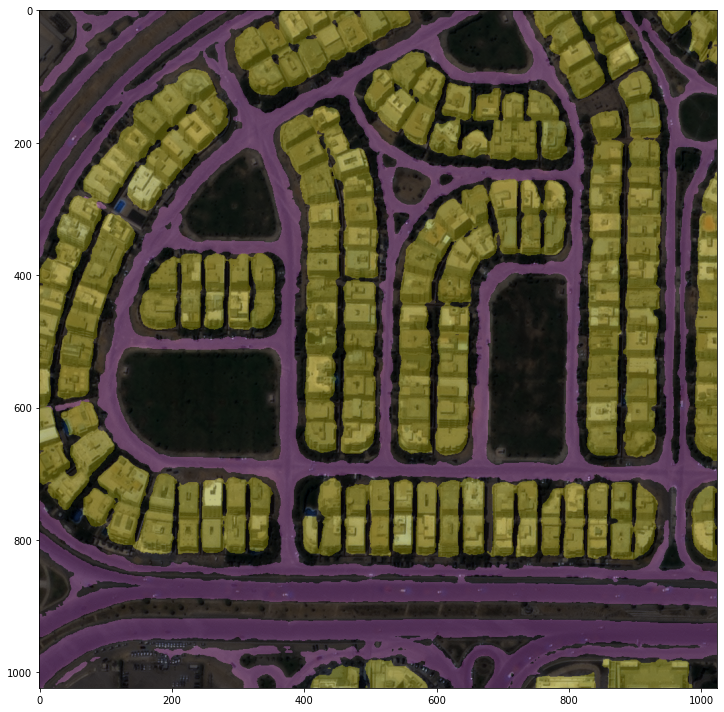

In [ ]:
from mmseg.datasets import build_dataset
from mmseg.models import build_segmentor
from mmseg.apis import train_segmentor

checkpoint_file = '/content/drive/MyDrive/SIA/semantic_checkpoint/Segformer/iter_6000.pth'  #학습된 모델

# checkpoint 저장된 model 파일을 이용하여 모델을 생성, 이때 Config는 위에서 update된 config 사용. 
model_ckpt = init_segmentor(cfg, checkpoint_file, device='cuda:0')  #cuda gpu 사용

img = mmcv.imread('/content/drive/MyDrive/SIA/images/up025/BLD00049_PS3_K3A_NIA0276.png')
result = inference_segmentor(model_ckpt, img)
show_result_pyplot(model_ckpt, img, result, palette)

/content/mmsegmentation/mmseg/models/backbones/mit.py:365: UserWarning: DeprecationWarning: pretrained is deprecated, please use "init_cfg" instead
  warnings.warn('DeprecationWarning: pretrained is deprecated, '
/content/mmsegmentation/mmseg/models/losses/cross_entropy_loss.py:236: UserWarning: Default ``avg_non_ignore`` is False, if you would like to ignore the certain label and average loss over non-ignore labels, which is the same with PyTorch official cross_entropy, set ``avg_non_ignore=True``.
  'Default ``avg_non_ignore`` is False, if you would like to '


load checkpoint from local path: /content/drive/MyDrive/SIA/semantic_checkpoint/Segformer/iter_6000.pth


/content/mmsegmentation/mmseg/models/segmentors/base.py:289: UserWarning: show==False and out_file is not specified, only result image will be returned
  warnings.warn('show==False and out_file is not specified, only '


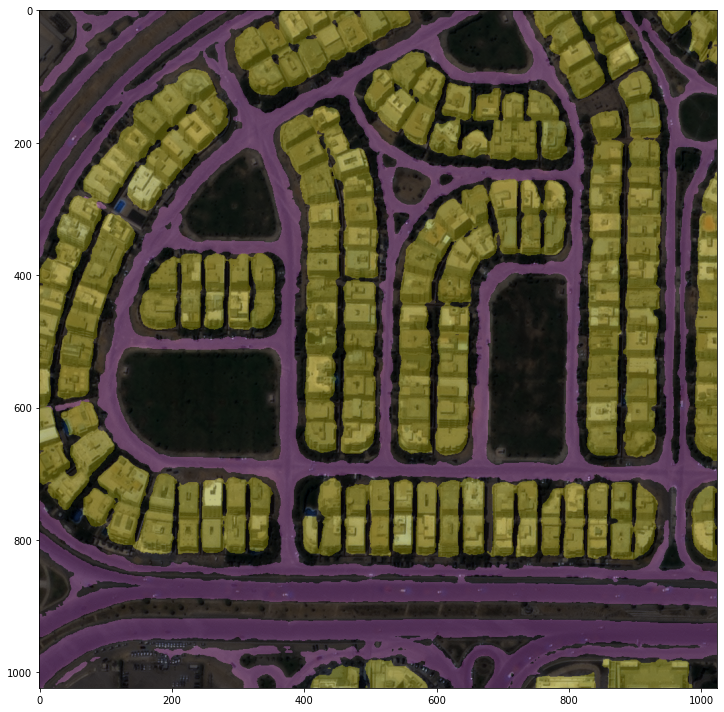

In [ ]:
checkpoint_file = '/content/drive/MyDrive/SIA/semantic_checkpoint/Segformer/iter_6000.pth'  #학습된 모델

# checkpoint 저장된 model 파일을 이용하여 모델을 생성, 이때 Config는 위에서 update된 config 사용. 
model_ckpt = init_segmentor(cfg, checkpoint_file, device='cuda:0')  #cuda gpu 사용

img = mmcv.imread('/content/drive/MyDrive/SIA/images/up025/BLD00049_PS3_K3A_NIA0276.png')
result = inference_segmentor(model_ckpt, img)
show_result_pyplot(model_ckpt, img, result, palette)

/content/mmsegmentation/mmseg/models/backbones/mit.py:365: UserWarning: DeprecationWarning: pretrained is deprecated, please use "init_cfg" instead
  warnings.warn('DeprecationWarning: pretrained is deprecated, '
/content/mmsegmentation/mmseg/models/losses/cross_entropy_loss.py:236: UserWarning: Default ``avg_non_ignore`` is False, if you would like to ignore the certain label and average loss over non-ignore labels, which is the same with PyTorch official cross_entropy, set ``avg_non_ignore=True``.
  'Default ``avg_non_ignore`` is False, if you would like to '


load checkpoint from local path: /content/drive/MyDrive/SIA/semantic_checkpoint/Segformer/iter_7000.pth


/content/mmsegmentation/mmseg/models/segmentors/base.py:289: UserWarning: show==False and out_file is not specified, only result image will be returned
  warnings.warn('show==False and out_file is not specified, only '


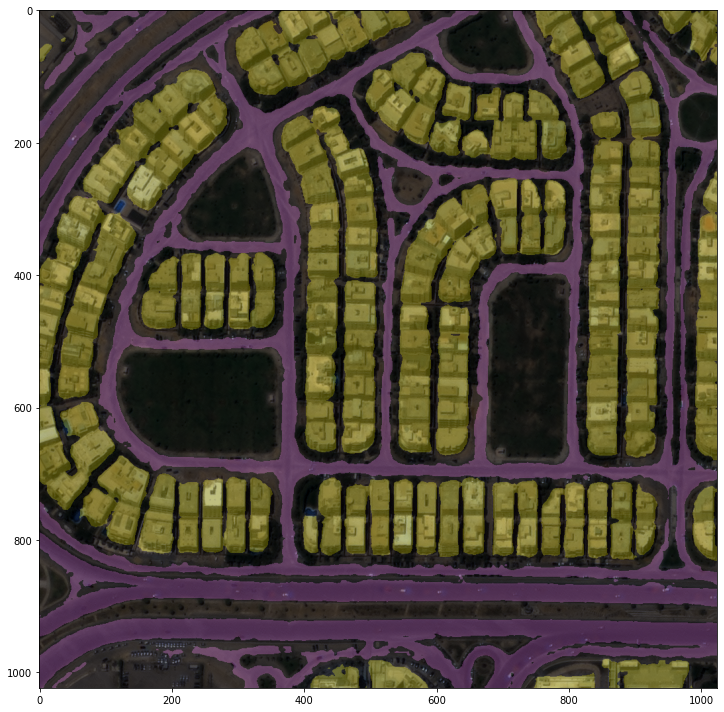

In [ ]:
checkpoint_file = '/content/drive/MyDrive/SIA/semantic_checkpoint/Segformer/iter_7000.pth'  #학습된 모델

# checkpoint 저장된 model 파일을 이용하여 모델을 생성, 이때 Config는 위에서 update된 config 사용. 
model_ckpt = init_segmentor(cfg, checkpoint_file, device='cuda:0')  #cuda gpu 사용

img = mmcv.imread('/content/drive/MyDrive/SIA/images/up025/BLD00049_PS3_K3A_NIA0276.png')
result = inference_segmentor(model_ckpt, img)
show_result_pyplot(model_ckpt, img, result, palette)

/content/mmsegmentation/mmseg/models/backbones/mit.py:365: UserWarning: DeprecationWarning: pretrained is deprecated, please use "init_cfg" instead
  warnings.warn('DeprecationWarning: pretrained is deprecated, '
/content/mmsegmentation/mmseg/models/losses/cross_entropy_loss.py:236: UserWarning: Default ``avg_non_ignore`` is False, if you would like to ignore the certain label and average loss over non-ignore labels, which is the same with PyTorch official cross_entropy, set ``avg_non_ignore=True``.
  'Default ``avg_non_ignore`` is False, if you would like to '


load checkpoint from local path: /content/drive/MyDrive/SIA/semantic_checkpoint/Segformer/iter_20000.pth


/content/mmsegmentation/mmseg/models/segmentors/base.py:289: UserWarning: show==False and out_file is not specified, only result image will be returned
  warnings.warn('show==False and out_file is not specified, only '


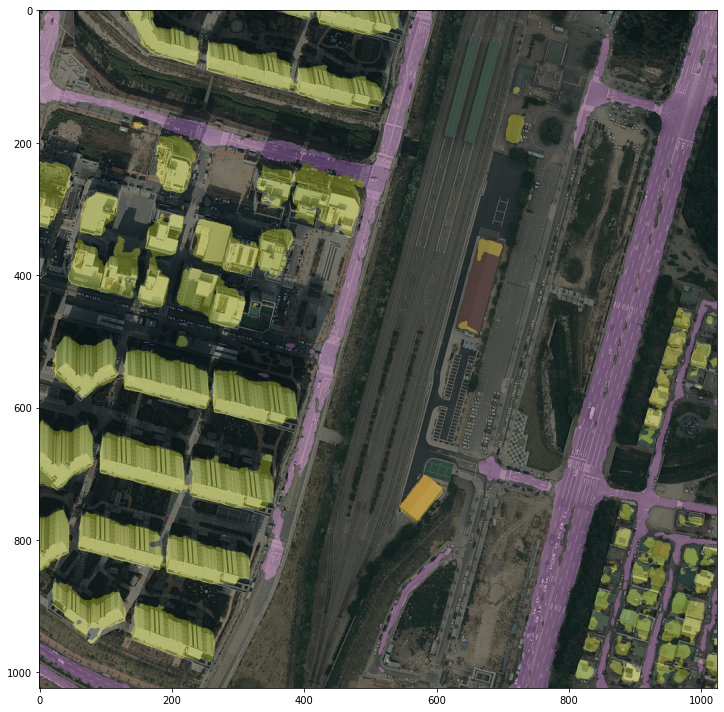

In [ ]:
checkpoint_file = '/content/drive/MyDrive/SIA/semantic_checkpoint/Segformer/iter_20000.pth'  #학습된 모델

# checkpoint 저장된 model 파일을 이용하여 모델을 생성, 이때 Config는 위에서 update된 config 사용. 
model_ckpt = init_segmentor(cfg, checkpoint_file, device='cuda:0')  #cuda gpu 사용

img = mmcv.imread('/content/drive/MyDrive/SIA/naver_map_images/0001.png')
result = inference_segmentor(model_ckpt, img)
show_result_pyplot(model_ckpt, img, result, palette)

/content/mmsegmentation/mmseg/models/backbones/mit.py:365: UserWarning: DeprecationWarning: pretrained is deprecated, please use "init_cfg" instead
  warnings.warn('DeprecationWarning: pretrained is deprecated, '
/content/mmsegmentation/mmseg/models/losses/cross_entropy_loss.py:236: UserWarning: Default ``avg_non_ignore`` is False, if you would like to ignore the certain label and average loss over non-ignore labels, which is the same with PyTorch official cross_entropy, set ``avg_non_ignore=True``.
  'Default ``avg_non_ignore`` is False, if you would like to '


load checkpoint from local path: /content/drive/MyDrive/SIA/semantic_checkpoint/Segformer/iter_20000.pth


/content/mmsegmentation/mmseg/models/segmentors/base.py:289: UserWarning: show==False and out_file is not specified, only result image will be returned
  warnings.warn('show==False and out_file is not specified, only '


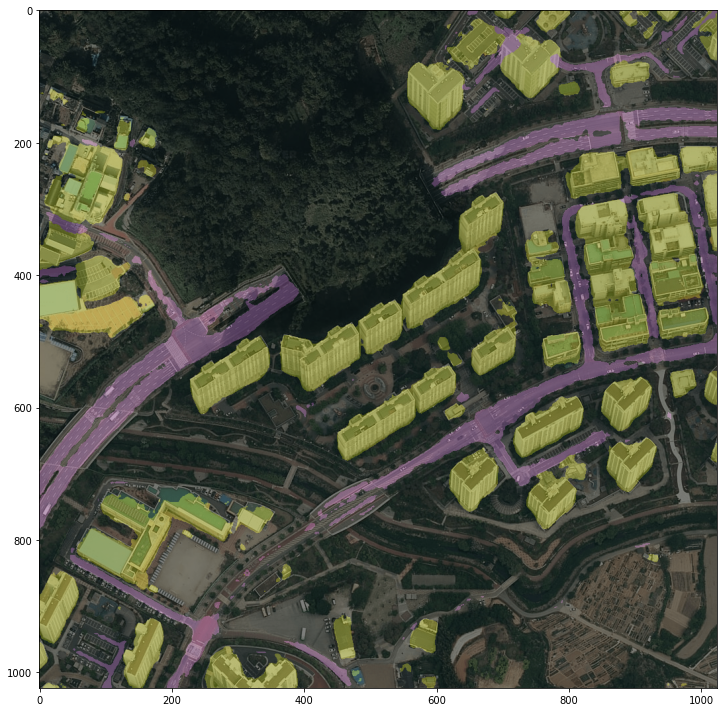

In [ ]:
checkpoint_file = '/content/drive/MyDrive/SIA/semantic_checkpoint/Segformer/iter_20000.pth'  #학습된 모델

# checkpoint 저장된 model 파일을 이용하여 모델을 생성, 이때 Config는 위에서 update된 config 사용. 
model_ckpt = init_segmentor(cfg, checkpoint_file, device='cuda:0')  #cuda gpu 사용

img = mmcv.imread('/content/drive/MyDrive/SIA/naver_map_images/0000.png')
result = inference_segmentor(model_ckpt, img)
show_result_pyplot(model_ckpt, img, result, palette)